# Baseline Model Evaluation: Helsinki-NLP opus-mt-fr-de

This notebook evaluates a pre-trained French→German translation model on our CJEU legal corpus to establish baseline performance before fine-tuning.

**Baseline Model:** Helsinki-NLP/opus-mt-fr-de (trained on OPUS parallel corpus)

**Evaluation Metrics:**
- BLEU (Bilingual Evaluation Understudy)
- chrF (Character n-gram F-score)
- TER (Translation Edit Rate)

**Goal:** Establish baseline scores to measure improvement after fine-tuning on legal domain data.

---

## 1. Setup and Imports

In [19]:
import sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Dict, Tuple
import re

# Add project root to path
project_root = Path("..").resolve()
sys.path.insert(0, str(project_root))

# Import our translator module
from src.models.translator import Translator

# Import evaluation metrics
import sacrebleu

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Set random seed for reproducibility
np.random.seed(42)

print("✅ Imports successful!")
print(f"SacreBLEU version: {sacrebleu.__version__}")

✅ Imports successful!
SacreBLEU version: 2.6.0


## 2. Load Data and Create Splits

Load the preprocessed parallel corpus and create train/validation/test splits (80/10/10).

In [20]:
# Load preprocessed data
data_path = project_root / "data" / "processed" / "parallel_paragraphs.jsonl"

data = []
with open(data_path, "r", encoding="utf-8") as f:
    for line in f:
        data.append(json.loads(line))

df = pd.DataFrame(data)

print(f"Loaded {len(df)} paragraph pairs")
print(f"Documents: {df['celex_id'].nunique()}")
df.head(3)

Loaded 964 paragraph pairs
Documents: 16


,id,source_text,target_text,celex_id,source_tokens,target_tokens,alignment_method,paragraph_number
0,62009CJ0296_para0001,La demande de décision préjudicielle porte sur...,Das Vorabentscheidungsersuchen betrifft die Au...,62009CJ0296,123,110,numbered_paragraph,1
1,62009CJ0296_para0002,Cette demande a été présentée dans le cadre d’...,Dieses Ersuchen ergeht im Rahmen eines Rechtss...,62009CJ0296,40,33,numbered_paragraph,2
2,62009CJ0296_para0003,"L’article 2 du règlement n° 1408/71, intitulé ...",Art. 2 („Persönlicher Geltungsbereich“) der Ve...,62009CJ0296,23,20,numbered_paragraph,3


In [21]:
# Create train/val/test split (80/10/10)
# Shuffle and split by document to avoid data leakage
unique_docs = df['celex_id'].unique()
np.random.shuffle(unique_docs)

n_docs = len(unique_docs)
n_train = int(0.8 * n_docs)
n_val = int(0.1 * n_docs)

train_docs = unique_docs[:n_train]
val_docs = unique_docs[n_train:n_train + n_val]
test_docs = unique_docs[n_train + n_val:]

# Create split masks
train_mask = df['celex_id'].isin(train_docs)
val_mask = df['celex_id'].isin(val_docs)
test_mask = df['celex_id'].isin(test_docs)

# Split dataframes
train_df = df[train_mask].reset_index(drop=True)
val_df = df[val_mask].reset_index(drop=True)
test_df = df[test_mask].reset_index(drop=True)

print("="*60)
print("DATA SPLITS")
print("="*60)
print(f"Train: {len(train_df)} paragraphs from {len(train_docs)} documents ({len(train_df)/len(df)*100:.1f}%)")
print(f"Val:   {len(val_df)} paragraphs from {len(val_docs)} documents ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test:  {len(test_df)} paragraphs from {len(test_docs)} documents ({len(test_df)/len(df)*100:.1f}%)")
print(f"Total: {len(df)} paragraphs from {len(unique_docs)} documents")
print("="*60)

DATA SPLITS
Train: 674 paragraphs from 12 documents (69.9%)
Val:   86 paragraphs from 1 documents (8.9%)
Test:  204 paragraphs from 3 documents (21.2%)
Total: 964 paragraphs from 16 documents


In [22]:
# Save split indices for reproducibility
splits_dir = project_root / "data" / "processed"
splits_dir.mkdir(exist_ok=True)

splits = {
    "train_indices": train_df.index.tolist(),
    "val_indices": val_df.index.tolist(),
    "test_indices": test_df.index.tolist(),
    "train_docs": train_docs.tolist(),
    "val_docs": val_docs.tolist(),
    "test_docs": test_docs.tolist(),
    "random_seed": 42,
    "split_method": "document-level",
    "split_ratio": "80/10/10",
}

splits_path = splits_dir / "data_splits.json"
with open(splits_path, "w", encoding="utf-8") as f:
    json.dump(splits, f, indent=2)

print(f"✅ Splits saved to: {splits_path}")

✅ Splits saved to: /workspaces/david/Documents/david/karriere/projects/french_german_translation/data/processed/data_splits.json


## 3. Load Baseline Model

Load the Helsinki-NLP opus-mt-fr-de model using our Translator wrapper.

In [23]:
# Load baseline translator
baseline_model_name = "Helsinki-NLP/opus-mt-fr-de"

print(f"Loading baseline model: {baseline_model_name}")
translator = Translator(
    model_name=baseline_model_name,
    max_length=512,
)

# Display model info
model_info = translator.get_model_info()
print("\n" + "="*60)
print("MODEL INFORMATION")
print("="*60)
for key, value in model_info.items():
    if 'parameters' in key:
        print(f"{key}: {value:,}")
    else:
        print(f"{key}: {value}")
print("="*60)

2026-02-14 16:10:43,945 - src.models.translator - INFO - Loading model: Helsinki-NLP/opus-mt-fr-de
2026-02-14 16:10:43,958 - src.models.translator - INFO - Using device: cpu


Loading baseline model: Helsinki-NLP/opus-mt-fr-de


2026-02-14 16:10:44,273 - httpx - INFO - HTTP Request: HEAD https://huggingface.co/Helsinki-NLP/opus-mt-fr-de/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-14 16:10:44,302 - httpx - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/Helsinki-NLP/opus-mt-fr-de/db80d261062d75a60e1d4897f13673313a33d50b/config.json "HTTP/1.1 200 OK"
2026-02-14 16:10:44,459 - httpx - INFO - HTTP Request: HEAD https://huggingface.co/Helsinki-NLP/opus-mt-fr-de/resolve/main/tokenizer_config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-14 16:10:44,483 - httpx - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/Helsinki-NLP/opus-mt-fr-de/db80d261062d75a60e1d4897f13673313a33d50b/tokenizer_config.json "HTTP/1.1 200 OK"
2026-02-14 16:10:44,632 - httpx - INFO - HTTP Request: GET https://huggingface.co/api/models/Helsinki-NLP/opus-mt-fr-de/tree/main/additional_chat_templates?recursive=false&expand=false "HTTP/1.1 404 Not Found"
2026-02-14 16:10:44,

Loading weights:   0%|          | 0/258 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie model.shared.weight to model.decoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.encoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
2026-02-14 16:10:55,661 - httpx - INFO - HTTP Request: HEAD https://huggingface.co/Helsinki-NLP/opus-mt-fr-de/resolve/main/generation_config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-14 16:10:55,690 - httpx - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/Helsinki-NLP/opus-mt-fr-de/db80d261062d75a60e1d4897f13673313a33d50b/generation_config.json "HTTP/1.1 200 OK"
2026-02-14 16:10:55,707 - src.models.translator


MODEL INFORMATION
model_name: Helsinki-NLP/opus-mt-fr-de
device: cpu
max_length: 512
num_parameters: 138,593,792
num_trainable_parameters: 138,593,792


## 4. Translate Test Set

Use the baseline model to translate all test set paragraphs.

In [24]:
# Extract source texts and references
test_sources = test_df['source_text'].tolist()
test_references = test_df['target_text'].tolist()

print(f"Translating {len(test_sources)} test paragraphs...")
print(f"Using beam search with num_beams=5")

# Translate test set
test_hypotheses = translator.translate_batch(
    test_sources,
    batch_size=8,
    num_beams=5,
    length_penalty=1.0,
    show_progress=True,
)

print(f"\n✅ Translation complete!")
print(f"Generated {len(test_hypotheses)} translations")

Translating 204 test paragraphs...
Using beam search with num_beams=5


Translating:   0%|          | 0/204 [00:00<?, ?it/s]

Translating: 100%|██████████| 204/204 [19:59<00:00,  5.88s/it]


✅ Translation complete!
Generated 204 translations


In [25]:
# Add translations to test dataframe
test_df['hypothesis'] = test_hypotheses

# Save test set with translations
test_output_path = project_root / "data" / "processed" / "test_set_with_baseline.jsonl"
test_df.to_json(test_output_path, orient='records', lines=True, force_ascii=False)

print(f"✅ Test set with translations saved to: {test_output_path}")

✅ Test set with translations saved to: /workspaces/david/Documents/david/karriere/projects/french_german_translation/data/processed/test_set_with_baseline.jsonl


## 5. Calculate Evaluation Metrics

Compute BLEU, chrF, and TER scores using SacreBLEU.

In [26]:
# Calculate corpus-level metrics using SacreBLEU
# SacreBLEU requires references as list of lists (for multiple references per source)
refs = [[ref] for ref in test_references]

# BLEU score
bleu = sacrebleu.corpus_bleu(test_hypotheses, refs)

# chrF score (character-level F-score)
chrf = sacrebleu.corpus_chrf(test_hypotheses, refs)

# TER (Translation Edit Rate)
ter = sacrebleu.corpus_ter(test_hypotheses, refs)

print("="*60)
print("BASELINE MODEL EVALUATION RESULTS")
print("="*60)
print(f"Model: {baseline_model_name}")
print(f"Test set size: {len(test_df)} paragraph pairs")
print(f"\nMetrics:")
print(f"  BLEU:  {bleu.score:.2f}")
print(f"  chrF:  {chrf.score:.2f}")
print(f"  TER:   {ter.score:.2f}")
print("\nInterpretation:")
print(f"  - BLEU: Higher is better (0-100). >30 is good for MT.")
print(f"  - chrF: Higher is better (0-100). More robust than BLEU.")
print(f"  - TER:  Lower is better. Measures edit distance.")
print("="*60)

BASELINE MODEL EVALUATION RESULTS
Model: Helsinki-NLP/opus-mt-fr-de
Test set size: 204 paragraph pairs

Metrics:
  BLEU:  55.51
  chrF:  72.23
  TER:   69.64

Interpretation:
  - BLEU: Higher is better (0-100). >30 is good for MT.
  - chrF: Higher is better (0-100). More robust than BLEU.
  - TER:  Lower is better. Measures edit distance.


In [27]:
# Calculate sentence-level BLEU scores for error analysis
sentence_bleu_scores = []

for hyp, ref in zip(test_hypotheses, test_references):
    # SacreBLEU sentence-level BLEU
    score = sacrebleu.sentence_bleu(hyp, [ref]).score
    sentence_bleu_scores.append(score)

test_df['bleu_score'] = sentence_bleu_scores

print(f"Sentence-level BLEU scores calculated")
print(f"Mean: {np.mean(sentence_bleu_scores):.2f}")
print(f"Median: {np.median(sentence_bleu_scores):.2f}")
print(f"Std: {np.std(sentence_bleu_scores):.2f}")
print(f"Min: {np.min(sentence_bleu_scores):.2f}")
print(f"Max: {np.max(sentence_bleu_scores):.2f}")

Sentence-level BLEU scores calculated
Mean: 37.50
Median: 36.18
Std: 17.25
Min: 4.03
Max: 100.00


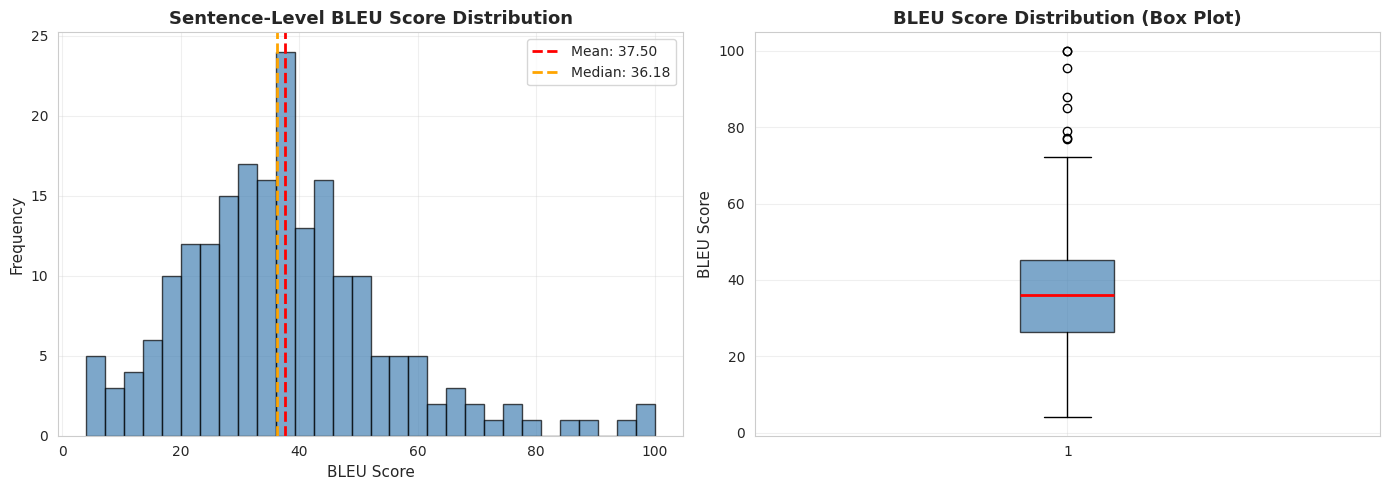

In [28]:
# Visualize BLEU score distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1.hist(sentence_bleu_scores, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(np.mean(sentence_bleu_scores), color='red', linestyle='--', linewidth=2,
            label=f'Mean: {np.mean(sentence_bleu_scores):.2f}')
ax1.axvline(np.median(sentence_bleu_scores), color='orange', linestyle='--', linewidth=2,
            label=f'Median: {np.median(sentence_bleu_scores):.2f}')
ax1.set_title('Sentence-Level BLEU Score Distribution', fontsize=13, fontweight='bold')
ax1.set_xlabel('BLEU Score', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.legend()
ax1.grid(alpha=0.3)

# Box plot
ax2.boxplot(sentence_bleu_scores, vert=True, patch_artist=True,
            boxprops=dict(facecolor='steelblue', alpha=0.7),
            medianprops=dict(color='red', linewidth=2))
ax2.set_title('BLEU Score Distribution (Box Plot)', fontsize=13, fontweight='bold')
ax2.set_ylabel('BLEU Score', fontsize=11)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Example Translations

Display sample translations to qualitatively assess translation quality.

In [29]:
# Show 10 random examples
np.random.seed(42)
sample_indices = np.random.choice(test_df.index, size=min(10, len(test_df)), replace=False)
samples = test_df.loc[sample_indices]

print("="*80)
print("SAMPLE TRANSLATIONS")
print("="*80)

for idx, row in samples.iterrows():
    print(f"\n[{row['id']}] BLEU: {row['bleu_score']:.2f}")
    print(f"\n🇫🇷 SOURCE:\n{row['source_text']}")
    print(f"\n🇩🇪 REFERENCE:\n{row['target_text']}")
    print(f"\n🤖 HYPOTHESIS (baseline):\n{row['hypothesis']}")
    print("\n" + "-"*80)

SAMPLE TRANSLATIONS

[62014CJ0573_para0016] BLEU: 15.86

🇫🇷 SOURCE:
L’article 12 de la directive 2004/83, intitulé « Exclusion » et figurant dans le chapitre III de celle-ci, lui-même intitulé « Conditions pour être considéré comme réfugié », dispose, à ses paragraphes 2 et 3 :

🇩🇪 REFERENCE:
Art. 12 („Ausschluss“) in Kapitel III („Anerkennung als Flüchtling“) der Richtlinie 2004/83 sieht in den Abs. 2 und 3 vor:

🤖 HYPOTHESIS (baseline):
Die Absätze 2 und 3 des Artikels 12 der Richtlinie 2004/83 mit der Bezeichnung "inländisch" und in Kapitel III dieser Richtlinie mit der Bezeichnung "Bedingungen für die Anerkennung als Flüchtling" enthalten:

--------------------------------------------------------------------------------

[62014CJ0573_para0010] BLEU: 26.61

🇫🇷 SOURCE:
La résolution 1624 (2005), adoptée le 14 septembre 2005 par le Conseil de sécurité, rappelle, notamment, que « tous les États doivent coopérer sans réserve à la lutte contre le terrorisme, conformément aux obligations 

## 7. Error Analysis

Identify paragraphs with lowest BLEU scores to understand model weaknesses.

In [30]:
# Find worst translations (lowest BLEU scores)
worst_translations = test_df.nsmallest(10, 'bleu_score')

print("="*80)
print("WORST TRANSLATIONS (Lowest BLEU Scores)")
print("="*80)

for idx, row in worst_translations.iterrows():
    print(f"\n[{row['id']}] BLEU: {row['bleu_score']:.2f} | Tokens (FR/DE): {row['source_tokens']}/{row['target_tokens']}")
    print(f"\n🇫🇷 SOURCE:\n{row['source_text'][:300]}{'...' if len(row['source_text']) > 300 else ''}")
    print(f"\n🇩🇪 REFERENCE:\n{row['target_text'][:300]}{'...' if len(row['target_text']) > 300 else ''}")
    print(f"\n🤖 HYPOTHESIS:\n{row['hypothesis'][:300]}{'...' if len(row['hypothesis']) > 300 else ''}")
    print("\n" + "-"*80)

WORST TRANSLATIONS (Lowest BLEU Scores)

[62008CJ0507_para0029] BLEU: 4.03 | Tokens (FR/DE): 35/29

🇫🇷 SOURCE:
L’introduction d’une action en recouvrement de celui-ci contre Frucona devant une juridiction interne aurait donc été le moyen adéquat d’y procéder, qui respecte les exigences d’immédiateté et d’efficacité.

🇩🇪 REFERENCE:
Die Erhebung einer Klage gegen Frucona auf Einziehung dieses Betrags bei einem innerstaatlichen Gericht sei demnach das adäquate Vorgehen gewesen und erfülle die Anforderungen der Unmittelbarkeit und Wirksamkeit.

🤖 HYPOTHESIS:
Die Einführung einer Klage auf Beitreibung von Frucona vor einem internen Gericht wäre somit das geeignete Mittel gewesen, um die sofortigen und wirksamen Erfordernisse zu erfüllen.

--------------------------------------------------------------------------------

[62008CJ0507_para0004] BLEU: 4.88 | Tokens (FR/DE): 14/10

🇫🇷 SOURCE:
Aux termes de l’article 23, paragraphe 1, du même règlement:

🇩🇪 REFERENCE:
Art. 23 Abs. 1 dieser Verord

In [31]:
# Find best translations (highest BLEU scores)
best_translations = test_df.nlargest(5, 'bleu_score')

print("="*80)
print("BEST TRANSLATIONS (Highest BLEU Scores)")
print("="*80)

for idx, row in best_translations.iterrows():
    print(f"\n[{row['id']}] BLEU: {row['bleu_score']:.2f}")
    print(f"\n🇫🇷 SOURCE:\n{row['source_text']}")
    print(f"\n🇩🇪 REFERENCE:\n{row['target_text']}")
    print(f"\n🤖 HYPOTHESIS:\n{row['hypothesis']}")
    print("\n" + "-"*80)

BEST TRANSLATIONS (Highest BLEU Scores)

[62014CJ0573_para0061] BLEU: 100.00

🇫🇷 SOURCE:
La troisième question est, en conséquence, recevable.

🇩🇪 REFERENCE:
Die dritte Frage ist daher zulässig.

🤖 HYPOTHESIS:
Die dritte Frage ist daher zulässig.

--------------------------------------------------------------------------------

[62003CJ0349_para0012] BLEU: 100.00

🇫🇷 SOURCE:
Selon l’article 2 de la directive 79/1070, les États membres mettent en vigueur les dispositions législatives, réglementaires et administratives nécessaires pour se conformer à cette directive au plus tard le 1er janvier 1981.

🇩🇪 REFERENCE:
Nach Artikel 2 der Richtlinie 79/1070 erlassen die Mitgliedstaaten die erforderlichen Rechts- und Verwaltungsvorschriften, um dieser Richtlinie spätestens am 1. Januar 1981 nachzukommen.

🤖 HYPOTHESIS:
Nach Artikel 2 der Richtlinie 79/1070 erlassen die Mitgliedstaaten die erforderlichen Rechts- und Verwaltungsvorschriften, um dieser Richtlinie spätestens am 1. Januar 1981 nachz


BLEU Scores by Paragraph Length:
                 mean     median  count
length_bin                             
0-50        38.244540  36.720563     61
50-100      39.545811  37.002987     89
100-150     32.204521  33.164089     45
150-200     42.183442  38.710821      5
200+        34.509085  34.325331      4


/tmp/ipykernel_81323/1374845389.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bleu_by_length = test_df.groupby('length_bin')['bleu_score'].agg(['mean', 'median', 'count'])


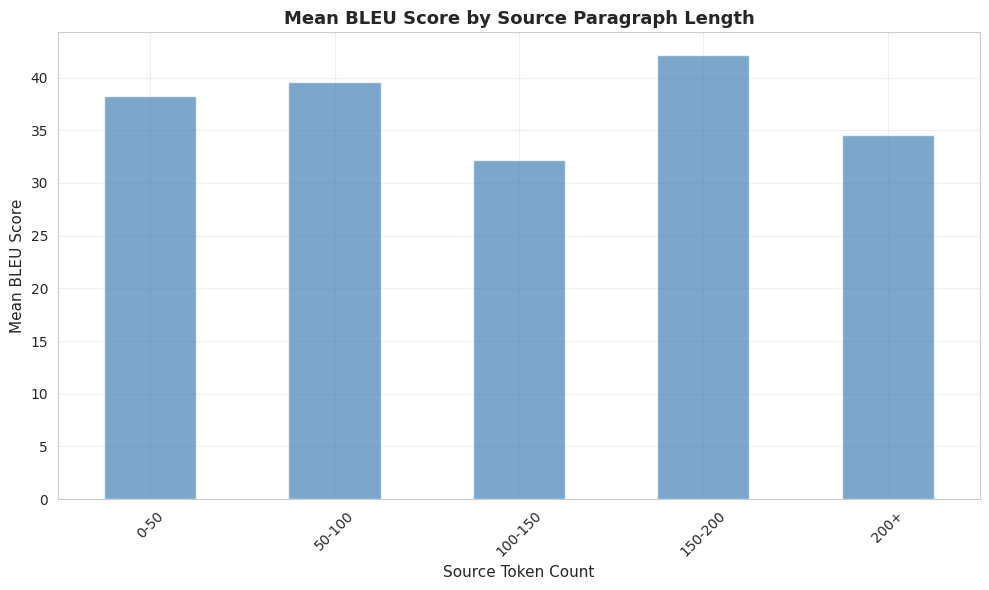

In [32]:
# Analyze BLEU scores by paragraph length
test_df['length_bin'] = pd.cut(
    test_df['source_tokens'],
    bins=[0, 50, 100, 150, 200, 500],
    labels=['0-50', '50-100', '100-150', '150-200', '200+']
)

bleu_by_length = test_df.groupby('length_bin')['bleu_score'].agg(['mean', 'median', 'count'])

print("\nBLEU Scores by Paragraph Length:")
print(bleu_by_length)

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
bleu_by_length['mean'].plot(kind='bar', color='steelblue', alpha=0.7, ax=ax)
ax.set_title('Mean BLEU Score by Source Paragraph Length', fontsize=13, fontweight='bold')
ax.set_xlabel('Source Token Count', fontsize=11)
ax.set_ylabel('Mean BLEU Score', fontsize=11)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Legal Term Translation Accuracy

Check how well the baseline model translates key legal terms.

In [33]:
# Define key legal term pairs (French → German expected translations)
legal_term_pairs = [
    (r'\barticle\b', r'\bartikel\b', 'article → artikel'),
    (r'\brèglement\b', r'\bverordnung\b', 'règlement → verordnung'),
    (r'\bdirective\b', r'\brichtlinie\b', 'directive → richtlinie'),
    (r'\btribunal\b', r'\bgericht\b', 'tribunal → gericht'),
    (r'\bcour\b', r'\bgerichtshof\b', 'cour → gerichtshof'),
    (r'\bjurisprudence\b', r'\brechtsprechung\b', 'jurisprudence → rechtsprechung'),
    (r'\bparagraphe\b', r'\babsatz\b', 'paragraphe → absatz'),
    (r'\btraité\b', r'\bvertrag\b', 'traité → vertrag'),
    (r'\barrêt\b', r'\burteil\b', 'arrêt → urteil'),
    (r'\bdemandeur\b', r'\bkläger\b', 'demandeur → kläger'),
]

def check_legal_term_accuracy(
    sources: List[str],
    hypotheses: List[str],
    references: List[str],
    term_pairs: List[Tuple[str, str, str]]
) -> Dict[str, Dict[str, int]]:
    """Check if legal terms are correctly translated."""
    results = {}
    
    for fr_pattern, de_pattern, label in term_pairs:
        correct = 0
        total = 0
        
        for src, hyp, ref in zip(sources, hypotheses, references):
            # Check if French term appears in source
            if re.search(fr_pattern, src, re.IGNORECASE):
                total += 1
                
                # Check if German term appears in both hypothesis and reference
                ref_has_term = bool(re.search(de_pattern, ref, re.IGNORECASE))
                hyp_has_term = bool(re.search(de_pattern, hyp, re.IGNORECASE))
                
                # Count as correct if hypothesis matches reference
                if ref_has_term and hyp_has_term:
                    correct += 1
                elif not ref_has_term and not hyp_has_term:
                    # Also correct if neither has it (term translated differently)
                    correct += 1
        
        if total > 0:
            results[label] = {
                'correct': correct,
                'total': total,
                'accuracy': correct / total * 100
            }
    
    return results

# Check legal term accuracy
term_accuracy = check_legal_term_accuracy(
    test_sources,
    test_hypotheses,
    test_references,
    legal_term_pairs
)

print("="*60)
print("LEGAL TERM TRANSLATION ACCURACY")
print("="*60)
for term, stats in term_accuracy.items():
    print(f"{term:35s} {stats['correct']:3d}/{stats['total']:3d} ({stats['accuracy']:5.1f}%)")
print("="*60)

# Calculate overall accuracy
total_correct = sum(s['correct'] for s in term_accuracy.values())
total_instances = sum(s['total'] for s in term_accuracy.values())
overall_accuracy = total_correct / total_instances * 100 if total_instances > 0 else 0

print(f"\nOverall legal term accuracy: {overall_accuracy:.1f}% ({total_correct}/{total_instances})")

LEGAL TERM TRANSLATION ACCURACY
article → artikel                    37/ 88 ( 42.0%)
règlement → verordnung               13/ 14 ( 92.9%)
directive → richtlinie               59/ 59 (100.0%)
tribunal → gericht                   12/ 12 (100.0%)
cour → gerichtshof                   18/ 22 ( 81.8%)
jurisprudence → rechtsprechung        4/  4 (100.0%)
paragraphe → absatz                  11/ 46 ( 23.9%)
traité → vertrag                     10/ 11 ( 90.9%)
arrêt → urteil                       30/ 30 (100.0%)
demandeur → kläger                    3/  3 (100.0%)

Overall legal term accuracy: 68.2% (197/289)


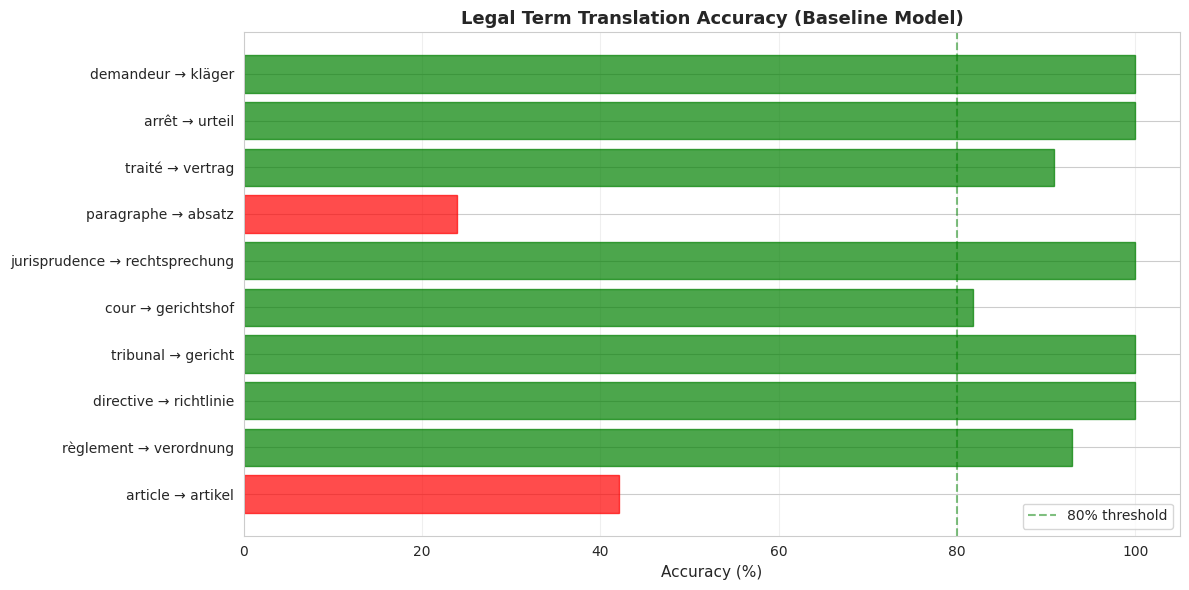

In [34]:
# Visualize legal term accuracy
if term_accuracy:
    terms = list(term_accuracy.keys())
    accuracies = [term_accuracy[t]['accuracy'] for t in terms]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.barh(range(len(terms)), accuracies, color='steelblue', alpha=0.7)
    
    # Color bars based on accuracy
    for i, (bar, acc) in enumerate(zip(bars, accuracies)):
        if acc >= 80:
            bar.set_color('green')
        elif acc >= 60:
            bar.set_color('orange')
        else:
            bar.set_color('red')
    
    ax.set_yticks(range(len(terms)))
    ax.set_yticklabels(terms, fontsize=10)
    ax.set_xlabel('Accuracy (%)', fontsize=11)
    ax.set_title('Legal Term Translation Accuracy (Baseline Model)', fontsize=13, fontweight='bold')
    ax.axvline(80, color='green', linestyle='--', alpha=0.5, label='80% threshold')
    ax.legend()
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 9. Save Results and Summary

In [35]:
# Save evaluation results
results = {
    "model": baseline_model_name,
    "test_set_size": len(test_df),
    "metrics": {
        "bleu": float(bleu.score),
        "chrf": float(chrf.score),
        "ter": float(ter.score),
    },
    "sentence_bleu": {
        "mean": float(np.mean(sentence_bleu_scores)),
        "median": float(np.median(sentence_bleu_scores)),
        "std": float(np.std(sentence_bleu_scores)),
        "min": float(np.min(sentence_bleu_scores)),
        "max": float(np.max(sentence_bleu_scores)),
    },
    "legal_term_accuracy": {
        "overall": float(overall_accuracy),
        "by_term": {k: v for k, v in term_accuracy.items()},
    },
    "generation_params": {
        "num_beams": 5,
        "length_penalty": 1.0,
        "max_length": 512,
    }
}

results_path = project_root / "results" / "baseline_evaluation.json"
results_path.parent.mkdir(exist_ok=True)

with open(results_path, "w", encoding="utf-8") as f:
    json.dump(results, f, indent=2)

print(f"✅ Results saved to: {results_path}")

✅ Results saved to: /workspaces/david/Documents/david/karriere/projects/french_german_translation/results/baseline_evaluation.json


In [36]:
# Print final summary
print("\n" + "="*80)
print("BASELINE EVALUATION SUMMARY")
print("="*80)
print(f"\n📊 Model: {baseline_model_name}")
print(f"📦 Test set: {len(test_df)} paragraph pairs from {len(test_docs)} documents")
print(f"\n📈 Overall Metrics:")
print(f"   BLEU:  {bleu.score:.2f}")
print(f"   chrF:  {chrf.score:.2f}")
print(f"   TER:   {ter.score:.2f}")
print(f"\n🎯 Legal Term Accuracy: {overall_accuracy:.1f}%")
print(f"\n💡 Key Findings:")
if bleu.score < 20:
    print(f"   ⚠️  BLEU score is low (<20), indicating the baseline struggles with legal domain")
    print(f"      → Fine-tuning on legal corpus is essential")
elif bleu.score < 30:
    print(f"   ⚠️  BLEU score is moderate (20-30), there's significant room for improvement")
    print(f"      → Fine-tuning should yield substantial gains")
else:
    print(f"   ✅ BLEU score is good (>30), but fine-tuning may still help with legal terminology")

if overall_accuracy < 70:
    print(f"   ⚠️  Legal term accuracy is low (<70%), domain adaptation needed")
elif overall_accuracy < 85:
    print(f"   ⚠️  Legal term accuracy is moderate (70-85%), can be improved")
else:
    print(f"   ✅ Legal term accuracy is high (>85%)")

print(f"\n🎯 Next Steps:")
print(f"   1. Fine-tune mBART-large-50 on the training set")
print(f"   2. Target BLEU improvement of +5 to +15 points")
print(f"   3. Prioritize legal term translation accuracy (target: >90%)")
print(f"   4. Monitor validation loss during fine-tuning")
print("="*80)


BASELINE EVALUATION SUMMARY

📊 Model: Helsinki-NLP/opus-mt-fr-de
📦 Test set: 204 paragraph pairs from 3 documents

📈 Overall Metrics:
   BLEU:  55.51
   chrF:  72.23
   TER:   69.64

🎯 Legal Term Accuracy: 68.2%

💡 Key Findings:
   ✅ BLEU score is good (>30), but fine-tuning may still help with legal terminology
   ⚠️  Legal term accuracy is low (<70%), domain adaptation needed

🎯 Next Steps:
   1. Fine-tune mBART-large-50 on the training set
   2. Target BLEU improvement of +5 to +15 points
   3. Prioritize legal term translation accuracy (target: >90%)
   4. Monitor validation loss during fine-tuning


---

## Evaluation Complete ✅

The baseline model has been evaluated and results saved. This establishes the benchmark for measuring improvement after fine-tuning on legal domain data.